In [1]:
import sys
sys.path.append("..")
from IPython.display import display

In [2]:
import numpy as np
import logging
import pickle
import time
import importlib 
import copy

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)

import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors
from matplotlib.patches import Ellipse
from matplotlib import gridspec



In [4]:
from scripts import reclusterTree
from scripts import linkageList
from scripts import heatClustermap
from scripts import Tree1D
from scripts import likelihood
from scripts import beamsearchTJS
from scripts import N2Greedy
from scripts import beamSearch as bs
from scripts import beamSearchOptimal as BSO
from scripts import jetClustering
from scripts.utils import get_logger
from scripts import auxFunctions

In [5]:
logger = get_logger(level=logging.INFO)

In [293]:
"""Reload filles after changes"""
importlib.reload(reclusterTree)
importlib.reload(linkageList)
importlib.reload(heatClustermap)
importlib.reload(Tree1D)
importlib.reload(likelihood)
importlib.reload(N2Greedy)
importlib.reload(bs)
importlib.reload(BSO)
importlib.reload(jetClustering)
importlib.reload(auxFunctions)

<module 'scripts.auxFunctions' from '/Users/sebastianmacaluso/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/auxFunctions.py'>

# CLUSTERING ALGORITHMS TESTED ON JETS GENERATED WITH THE TOY GENERATIVE MODEL 

### RUN GREEDY AND BEAM SEARCH ALGORITHMS

In [7]:
def runGreedy_Scan(start, end, Njets):
        """ Run greedy algorithm"""
        
        for i in range(start,end):
            jetsList, jetsListLogLH = jetClustering.fill_GreedyList("tree_"+str(Njets)+"_truth_"+str(i), k1 = 0, k2 = Njets)
            
            with open("data/GreedyJets/Greedy_"+str(Njets)+"Mw_"+str(i)+".pkl", "wb") as f: 
                pickle.dump((jetsList, jetsListLogLH), f) 

In [8]:
"""We ran a scan for 30 sets of 500 jets each."""

Nstart = 10
Nend = 30
N_jets = 500

runGreedyScan = False

if runGreedyScan==True:
    runGreedy_Scan(Nstart,Nend,N_jets)

In [9]:
def runBSO_Scan(start, end, Njets):
        """ Run beam search algorithm"""
        
        for i in range(start,end):
            BSO_jetsList, BSO_jetsListLogLH = jetClusteringfill_BSList("tree_"+str(Njets)+"_truth_"+str(i), k1 = 0, k2 = Njets)
            
            with open("data/BeamSearchJets/BSO_"+str(Njets)+"Mw_"+str(i)+".pkl", "wb") as f: 
                pickle.dump((BSO_jetsList,BSO_jetsListLogLH), f) 

In [10]:
"""We ran a scan for 10 sets of 500 jets each. (Below as an example there is a scan for 4 sets of 2 jets each)"""

Nstart = 0
Nend = 4
N_jets = 2

runBSOScan = False

if runBSOScan==True:
    runBSO_Scan(Nstart,Nend,N_jets)

## ANALYSIS

Load truth and reclustered jets 

In [208]:
Nstart = 0
Nend = 30
N_jets = 500

In [209]:
truthDict  = jetClustering.appendTruthJets(Nstart,Nend,N_jets)

In [210]:
GreedyDict = jetClustering.appendGreedyJets(Nstart,Nend,N_jets)

2019-10-09 00:49:48,110:INFO:: TOTAL TIME = 1412.1542088985443


In [211]:
BSODict = jetClustering.appendBSO_Scan(Nstart,Nend,N_jets)

2019-10-09 01:12:45,750:INFO:: TOTAL TIME = 1377.5876438617706


In [379]:
# truthDict = auxFunctions.scanJets(truthDict, dijmetrics=True,  angles=True)

In [383]:
# GreedyDict = auxFunctions.scanJets(GreedyDict, dijmetrics=True,  angles=True)

In [384]:
# BSODict = auxFunctions.scanJets(BSODict, dijmetrics=True,  angles=True)

In [437]:
len(GreedyDict["JetsConstPhi"])

561991

Log LH values before cut on Delta root 

In [444]:
print(" Truth mean logLH =  %0.1f $\pm$ %0.1f" %(np.average(truthDict["avgLogLH"]),  truthDict["sigma"]))
print(" Greedy mean logLH = %0.1f $\pm$ %0.1f" %(np.average(GreedyDict["avgLogLH"]),  GreedyDict["sigma"]))
print(" Beam Search mean logLH = %0.1f $\pm$ %0.1f" %(np.average(BSODict["avgLogLH"]),  BSODict["sigma"]))

 Truth mean logLH =  -85.4 $\pm$ 2.1
 Greedy mean logLH = -128.1 $\pm$ 2.9
 Beam Search mean logLH = -97.7 $\pm$ 2.4


### PLOTS

In [445]:
importlib.reload(auxFunctions)

<module 'scripts.auxFunctions' from '/Users/sebastianmacaluso/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/auxFunctions.py'>

In [446]:
Width = 20

In [447]:
truth_dic, Greedy_dic, BSO_dic = auxFunctions.deltaRootCut(Nstart,Nend, truthDict, GreedyDict, BSODict, Width = Width )

In [448]:
len(BSO_dic["jetsList"][0] )

88

In [449]:
truth_dic =auxFunctions.jetsLogLH(Nstart,Nend, truth_dic)
Greedy_dic =auxFunctions.jetsLogLH(Nstart,Nend, Greedy_dic)
BSO_dic =auxFunctions.jetsLogLH(Nstart,Nend, BSO_dic)

In [450]:
len(BSO_dic["jetsList"])

2279

In [451]:
print(" Truth mean logLH =  %0.1f $\pm$ %0.1f" %(np.average(truth_dic["avgLogLH"]),  truth_dic["sigma"]))
print(" Greedy mean logLH = %0.1f $\pm$ %0.1f" %(np.average(Greedy_dic["avgLogLH"]),  Greedy_dic["sigma"]))
print(" Beam Search mean logLH = %0.1f $\pm$ %0.1f" %(np.average(BSO_dic["avgLogLH"]),  BSO_dic["sigma"]))

 Truth mean logLH =  -47.3 $\pm$ 3.4
 Greedy mean logLH = -62.8 $\pm$ 5.4
 Beam Search mean logLH = -49.1 $\pm$ 4.0


In [452]:
# print(" Truth mean logLH =  %0.1f $\pm$ %0.1f +- %0.1f" 
#       %(np.average(truth_dic["avgLogLH"]),  truth_dic["sigma"],  truth_dic["statSigma"]))
# print(" Greedy mean logLH = %0.1f $\pm$ %0.1f +- %0.1f" 
#       %(np.average(Greedy_dic["avgLogLH"]),  Greedy_dic["sigma"],  Greedy_dic["statSigma"]))
# print(" Beam Search mean logLH = %0.1f $\pm$ %0.1f +- %0.1f" 
#       %(np.average(BSO_dic["avgLogLH"]),  BSO_dic["sigma"],  BSO_dic["statSigma"]))

#### LOG LIKELIHOOD

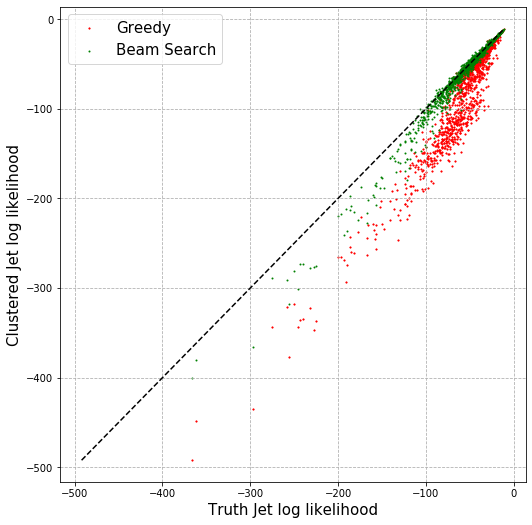

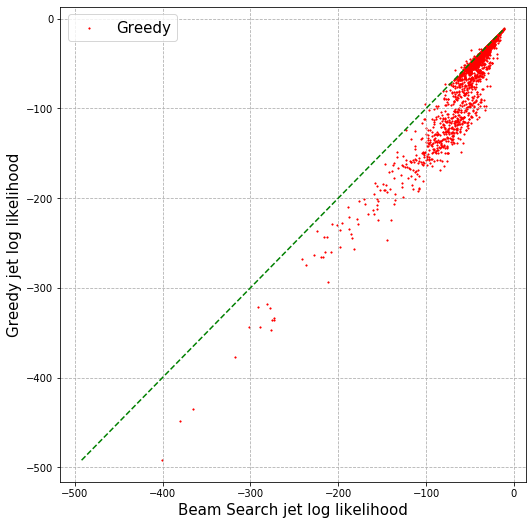

In [453]:
auxFunctions.LogLHscatterPlot(truth_dic, Greedy_dic, BSO_dic)
auxFunctions.LogLHscatterPlot(truth_dic, Greedy_dic, BSO_dic, truth=False)

### Delta root

In [454]:
truth_dic = auxFunctions.deltaRoot(truth_dic)

In [455]:
Greedy_dic = auxFunctions.deltaRoot(Greedy_dic)

In [456]:
BSO_dic = auxFunctions.deltaRoot(BSO_dic)

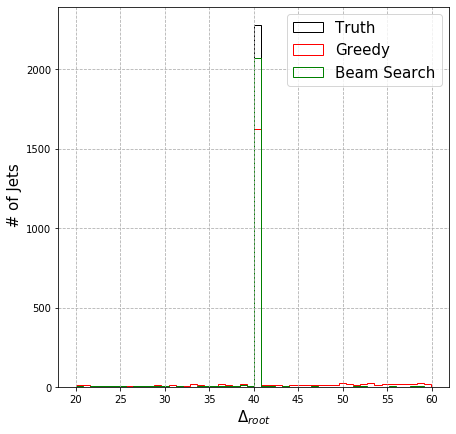

In [457]:
auxFunctions.variableHist(truth_dic, 
    variable1 =  truth_dic["deltaRoot"], 
    variable2 = Greedy_dic["deltaRoot"], 
    variable3 = BSO_dic["deltaRoot"],
             name = "$\Delta_{root}$")

### Momentum of the 2 subjets

In [458]:
truth_dic = auxFunctions.subjetPt(truth_dic)

In [459]:
Greedy_dic = auxFunctions.subjetPt(Greedy_dic)

In [460]:
BSO_dic = auxFunctions.subjetPt(BSO_dic)

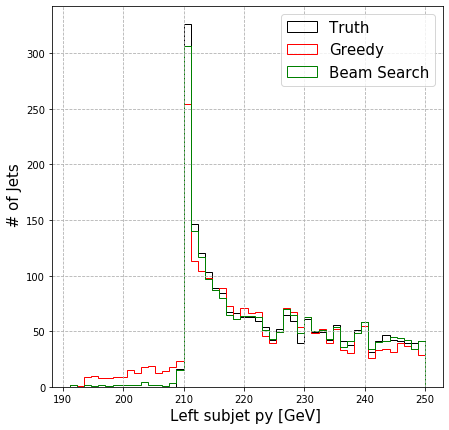

In [461]:
auxFunctions.variableHist( truth_dic, 
    variable1 =  truth_dic["SubjetPyMin"], 
    variable2 = Greedy_dic["SubjetPyMin"], 
    variable3 = BSO_dic["SubjetPyMin"],
             name = "Left subjet py [GeV]")

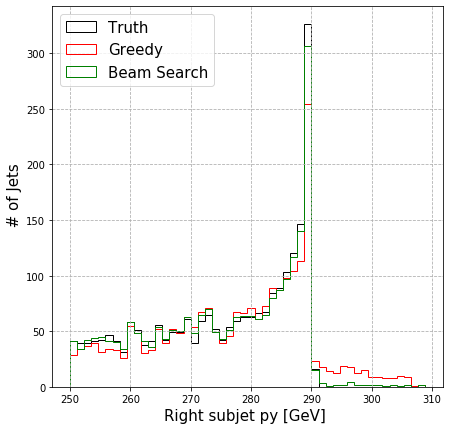

In [462]:
auxFunctions.variableHist(    truth_dic, 
    variable1 =  truth_dic["SubjetPyMax"], 
    variable2 = Greedy_dic["SubjetPyMax"], 
    variable3 = BSO_dic["SubjetPyMax"],
             name = "Right subjet py [GeV]",
                         labelLoc = "upper left")

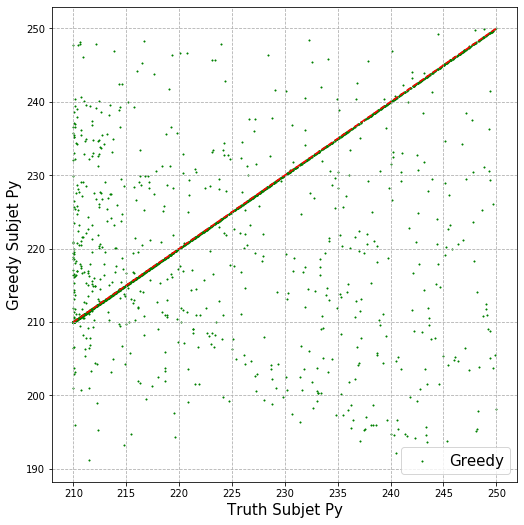

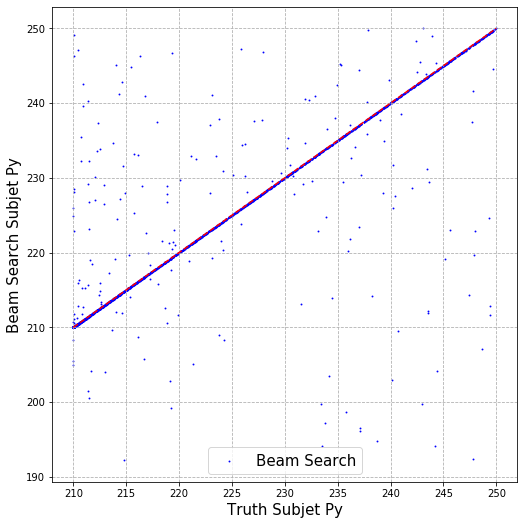

In [463]:
auxFunctions.PtscatterPlot(truth_dic, Greedy_dic, BSO_dic,  dicString = "SubjetPyMin", Greedy=True)
auxFunctions.PtscatterPlot(truth_dic, Greedy_dic, BSO_dic, dicString = "SubjetPyMin",  BS=True)


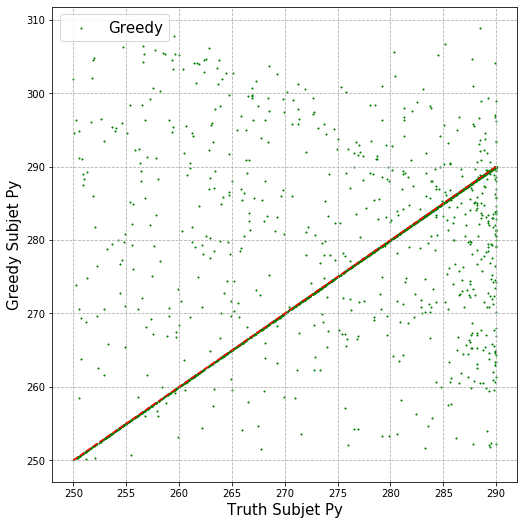

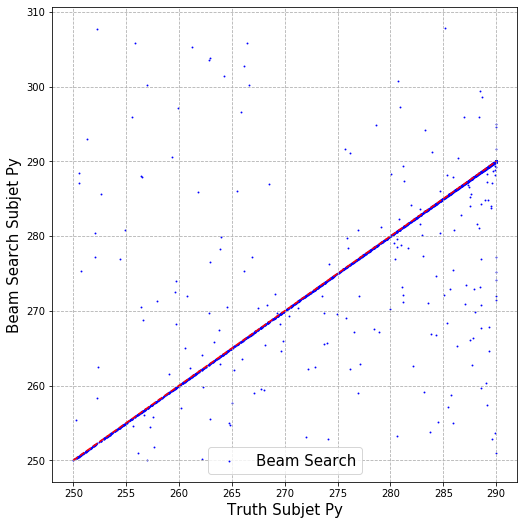

In [464]:
auxFunctions.PtscatterPlot(truth_dic, Greedy_dic, BSO_dic,  dicString = "SubjetPyMax", Greedy=True)
auxFunctions.PtscatterPlot(truth_dic, Greedy_dic, BSO_dic, dicString = "SubjetPyMax",  BS=True)

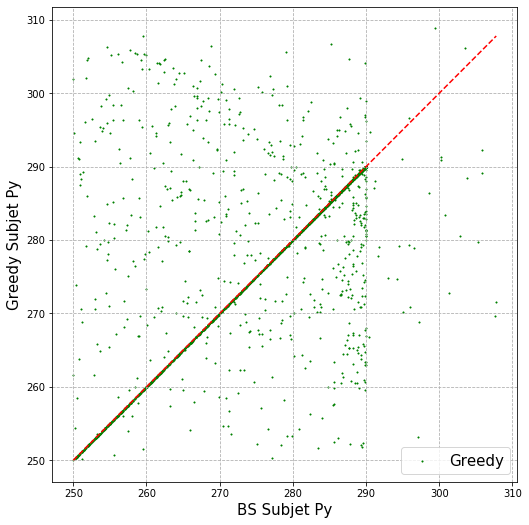

In [465]:
auxFunctions.PtscatterPlot(truth_dic, Greedy_dic, BSO_dic, dicString = "SubjetPyMax")

### Phi angle for the (y,z) plane. Constituents angle, delta_root angle and delta_parent angle for all parents

In [466]:
importlib.reload(auxFunctions)

<module 'scripts.auxFunctions' from '/Users/sebastianmacaluso/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/auxFunctions.py'>

In [467]:
truth_dic = auxFunctions.subjetPhi(truth_dic)

In [468]:
Greedy_dic = auxFunctions.subjetPhi(Greedy_dic)

In [469]:
BSO_dic = auxFunctions.subjetPhi(BSO_dic)

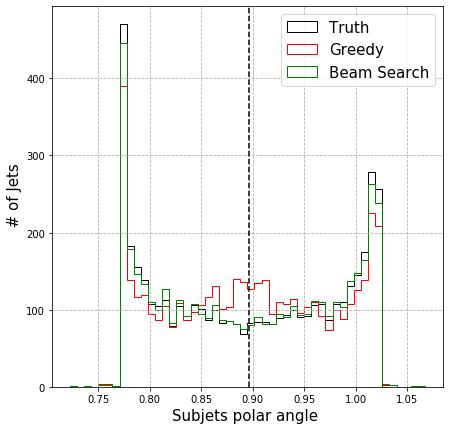

In [470]:
auxFunctions.variableHist(
    truth_dic, 
    variable1 =  truth_dic["SubjetPhi"], 
    variable2 = Greedy_dic["SubjetPhi"], 
    variable3 = BSO_dic["SubjetPhi"],
             bins=50,
             name = "Subjets polar angle",
             fixedJetP = True)

In [471]:
truth_dic = auxFunctions.scanJets(truth_dic, angles=True)

In [472]:
Greedy_dic = auxFunctions.scanJets(Greedy_dic, angles=True)

In [473]:
BSO_dic = auxFunctions.scanJets(BSO_dic, angles=True)

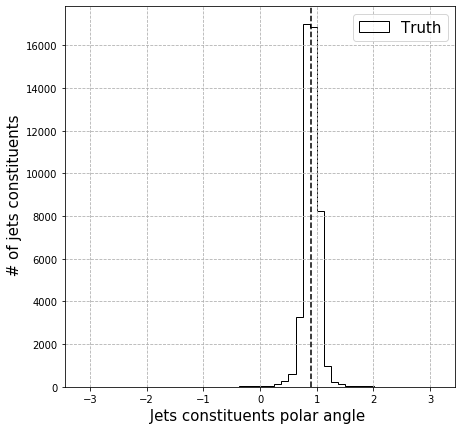

In [474]:
""" Subjets constituents angle. The origin is in the beam axiz (z direction)"""
auxFunctions.ConstPhiHist(truth_dic, fixedJetP = True)

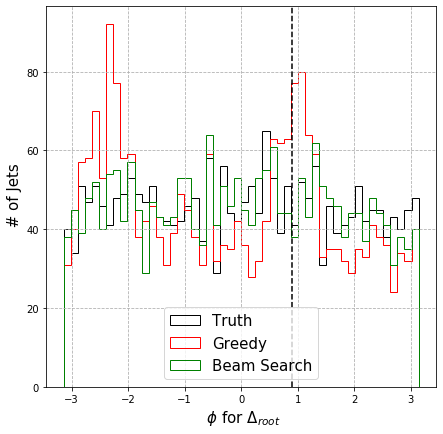

In [475]:
auxFunctions.variableHist(
    truth_dic, 
    variable1 =  truth_dic["SubjetPhiDelta"], 
    variable2 = Greedy_dic["SubjetPhiDelta"], 
    variable3 = BSO_dic["SubjetPhiDelta"],
             bins=50,
             name = " $\phi$ for $\Delta_{root}$",
             fixedJetP = True,
labelLoc = "lower center")

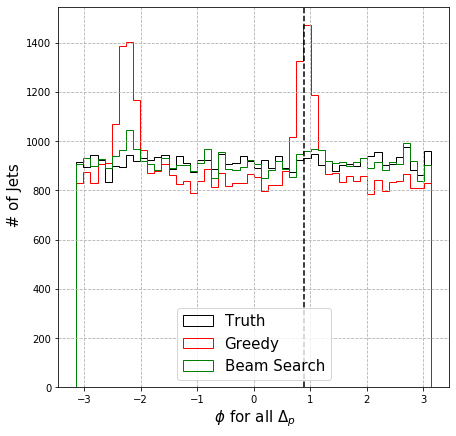

In [476]:
auxFunctions.variableHist(
    truth_dic, 
    variable1 =  truth_dic["JetsPhiDelta"], 
    variable2 = Greedy_dic["JetsPhiDelta"], 
    variable3 = BSO_dic["JetsPhiDelta"],
             bins=50,
             name = " $\phi$ for all $\Delta_p$",
             fixedJetP = True,
labelLoc = "lower center")

In [477]:
Nconst = [len(jet["leaves"]) for jet in truth_dic["jetsList"]]

In [478]:
""" Find jet location in list for a specific number of leaves"""
for i,N in enumerate(Nconst):
    if N>110:
        print("Jet #",i,"N const = ",N )

Jet # 895 N const =  148
Jet # 1007 N const =  146
Jet # 1243 N const =  130
Jet # 1263 N const =  119
Jet # 1563 N const =  121


In [479]:
# k=1263
# auxFunctions.variableHist(
#     truth_dic, 
#     variable1 =  truth_dic["jetsList"][k]["PhiDelta"], 
#     variable2 = Greedy_dic["jetsList"][k]["PhiDelta"], 
#     variable3 = BSO_dic["jetsList"][k]["PhiDelta"],
#              bins=10,
#              name = " Jets inner node Delta angle  ",
#             yaxisName = " # of jet inner nodes",
#              fixedJetP = True)


### $d_{ij}$ vs log Likelihood

In [480]:
importlib.reload(auxFunctions)

<module 'scripts.auxFunctions' from '/Users/sebastianmacaluso/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/auxFunctions.py'>

In [481]:
truth_dic = auxFunctions.scanJets(truth_dic, dijmetrics=True)

In [482]:
Greedy_dic = auxFunctions.scanJets(Greedy_dic, dijmetrics=True)

In [483]:
BSO_dic = auxFunctions.scanJets(BSO_dic, dijmetrics=True)

In [484]:
np.shape(Greedy_dic["dijs"])

(4, 45755)

In [485]:
np.shape(truth_dic["dijSubjets"])

(4, 2279)

In [486]:


# auxFunctions.dijLogLHscatter(
#     variable = truth_dic["dijSubjets"],
#     nameY = "Subjets $d_{ij}$",
#     nameX ="Subjet splitting log likelihood",
#     title = "Truth jets",
#     logLH =True)

# auxFunctions.dijLogLHscatter(
#     variable = truth_dic["dijs"],
#     nameX = "$d_{ij}$",
#     nameY ="Splitting log likelihood",
#     title = "Truth jets",
#     logLH = True)

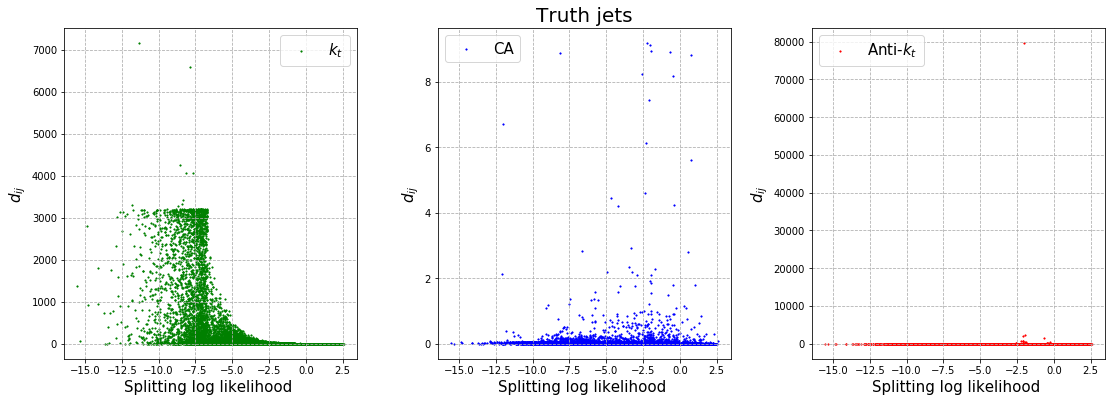

In [487]:
jetdijs = truth_dic["dijs"]
nameY = "$d_{ij}$"
nameX ="Splitting log likelihood"
title = "Truth jets"
# jetdijs2 = BSO_dic["dijs"]
# jetdijs3 = Greedy_dic["dijs"]
LabelJetdijs = "$k_t$"
LabelJetdijs2 = "CA"
LabelJetdijs3 = "Anti-$k_t$"


fig2, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig2.set_size_inches(15, 5)

plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)
markersize = 1

ax1.scatter(jetdijs[0], jetdijs[3], color="green", marker="X", s=markersize, label=LabelJetdijs)
ax2.scatter(jetdijs[0], jetdijs[2], color="blue", marker="X", s=markersize, label=LabelJetdijs2)
ax3.scatter(jetdijs[0], jetdijs[1], color="red", marker="X", s=markersize, label=LabelJetdijs3)

ax1.legend(loc="best",  fontsize=15)
ax1.set_xlabel(r"%s "%nameX, fontsize=15)
ax1.set_ylabel(r"%s "%nameY, fontsize=15)
ax1.grid(which='both', axis='both', linestyle='--')

ax2.legend(loc="best",  fontsize=15)
ax2.set_xlabel(r"%s "%nameX, fontsize=15)
ax2.set_ylabel(r"%s "%nameY, fontsize=15)
ax2.grid(which='both', axis='both', linestyle='--')

ax3.legend(loc="best",  fontsize=15)
ax3.set_xlabel(r"%s "%nameX, fontsize=15)
ax3.set_ylabel(r"%s "%nameY, fontsize=15)
ax3.grid(which='both', axis='both', linestyle='--')




# plt.legend(loc='best', fontsize=15)
# plt.grid(which='both', axis='both', linestyle='--')
ax2.set_title(r"%s"%title, fontsize=20)
plt.show()

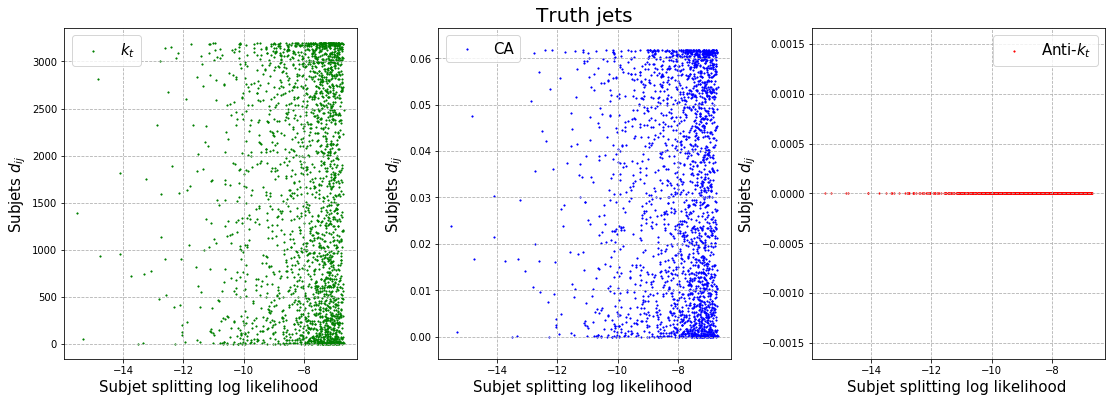

In [488]:
jetdijs = truth_dic["dijSubjets"]
nameY = "Subjets $d_{ij}$"
nameX ="Subjet splitting log likelihood"
title = "Truth jets"
# jetdijs2 = BSO_dic["dijs"]
# jetdijs3 = Greedy_dic["dijs"]
LabelJetdijs = "$k_t$"
LabelJetdijs2 = "CA"
LabelJetdijs3 = "Anti-$k_t$"


fig2, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig2.set_size_inches(15, 5)

plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)
markersize = 1

ax1.scatter(jetdijs[0], jetdijs[3], color="green", marker="X", s=markersize, label=LabelJetdijs)
ax2.scatter(jetdijs[0], jetdijs[2], color="blue", marker="X", s=markersize, label=LabelJetdijs2)
ax3.scatter(jetdijs[0], jetdijs[1], color="red", marker="X", s=markersize, label=LabelJetdijs3)

ax1.legend(loc="best",  fontsize=15)
ax1.set_xlabel(r"%s "%nameX, fontsize=15)
ax1.set_ylabel(r"%s "%nameY, fontsize=15)
ax1.grid(which='both', axis='both', linestyle='--')

ax2.legend(loc="best",  fontsize=15)
ax2.set_xlabel(r"%s "%nameX, fontsize=15)
ax2.set_ylabel(r"%s "%nameY, fontsize=15)
ax2.grid(which='both', axis='both', linestyle='--')

ax3.legend(loc="best",  fontsize=15)
ax3.set_xlabel(r"%s "%nameX, fontsize=15)
ax3.set_ylabel(r"%s "%nameY, fontsize=15)
ax3.grid(which='both', axis='both', linestyle='--')




# plt.legend(loc='best', fontsize=15)
# plt.grid(which='both', axis='both', linestyle='--')
ax2.set_title(r"%s"%title, fontsize=20)
plt.show()

No handles with labels found to put in legend.


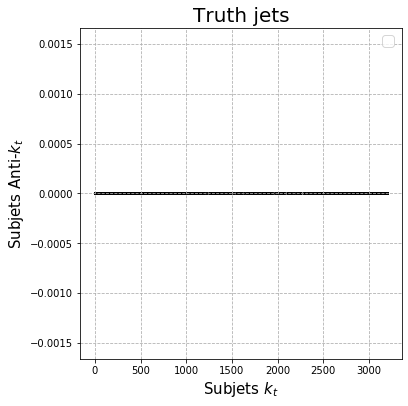

No handles with labels found to put in legend.


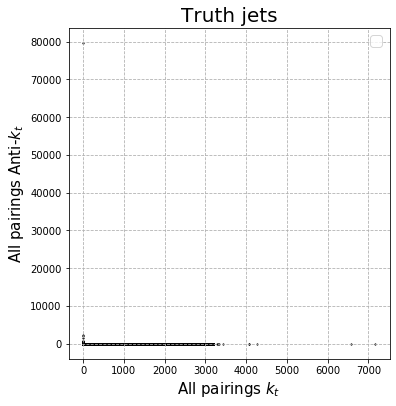

In [489]:
auxFunctions.dijLogLHscatter(
    variable = truth_dic["dijSubjets"],
    nameX = "Subjets $k_t$",
    nameY ="Subjets Anti-$k_t$",
    title = "Truth jets",
    dijOnly =True)

auxFunctions.dijLogLHscatter(
    variable = truth_dic["dijs"],
    nameX = "All pairings $k_t$",
    nameY ="All pairings Anti-$k_t$",
    title = "Truth jets",
    dijOnly = True)

In [490]:
# auxFunctions.dijLogLHscatter(
#     variable = truth_dic["dijs"],
#     nameY = "$k_t$",
#     nameX ="Splitting log likelihood",
#     title = "",
#     kt = True,
#     jetdijs2 = BSO_dic["dijs"],
#     jetdijs3 = Greedy_dic["dijs"],
#     LabelJetdijs = "Truth",
#     LabelJetdijs2 = "BS",
#     LabelJetdijs3 = "Greedy",
#                     )

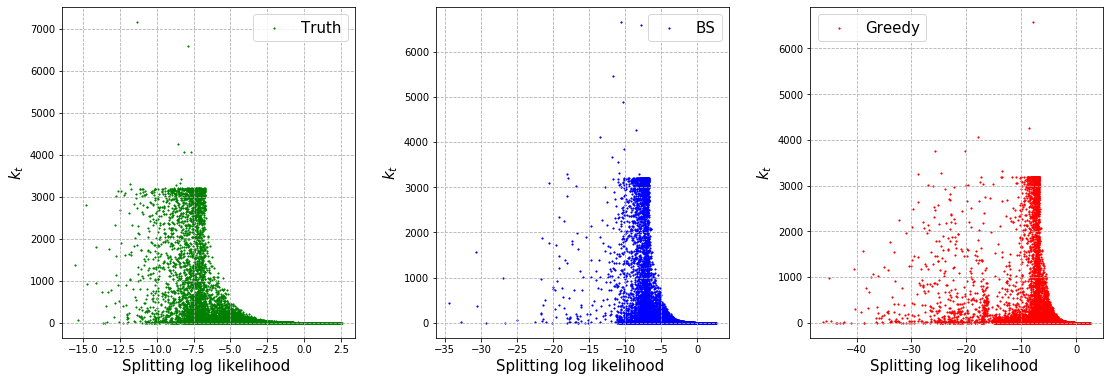

In [491]:
jetdijs = truth_dic["dijs"]
nameY = "$k_t$"
nameX ="Splitting log likelihood"
title = ""
jetdijs2 = BSO_dic["dijs"]
jetdijs3 = Greedy_dic["dijs"]
LabelJetdijs = "Truth"
LabelJetdijs2 = "BS"
LabelJetdijs3 = "Greedy"


fig2, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig2.set_size_inches(15, 5)

plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)
markersize = 1

ax1.scatter(jetdijs[0], jetdijs[3], color="green", marker="X", s=markersize, label=LabelJetdijs)
ax2.scatter(jetdijs2[0], jetdijs2[3], color="blue", marker="X", s=markersize, label=LabelJetdijs2)
ax3.scatter(jetdijs3[0], jetdijs3[3], color="red", marker="X", s=markersize, label=LabelJetdijs3)

ax1.legend(loc="best",  fontsize=15)
ax1.set_xlabel(r"%s "%nameX, fontsize=15)
ax1.set_ylabel(r"%s "%nameY, fontsize=15)
ax1.grid(which='both', axis='both', linestyle='--')

ax2.legend(loc="best",  fontsize=15)
ax2.set_xlabel(r"%s "%nameX, fontsize=15)
ax2.set_ylabel(r"%s "%nameY, fontsize=15)
ax2.grid(which='both', axis='both', linestyle='--')

ax3.legend(loc="best",  fontsize=15)
ax3.set_xlabel(r"%s "%nameX, fontsize=15)
ax3.set_ylabel(r"%s "%nameY, fontsize=15)
ax3.grid(which='both', axis='both', linestyle='--')




# plt.legend(loc='best', fontsize=15)
plt.grid(which='both', axis='both', linestyle='--')
plt.title(r"%s"%title, fontsize=20)
plt.show()

In [492]:
# auxFunctions.dijLogLHscatter(
#     variable = truth_dic["dijs"],
#     nameY = "Anti-$k_t$",
#     nameX ="Splitting log likelihood",
#     title = "",
#     antikt = True,
#     jetdijs2 = BSO_dic["dijs"],
#     jetdijs3 = Greedy_dic["dijs"],
#     LabelJetdijs = "Truth",
#     LabelJetdijs2 = "BS",
#     LabelJetdijs3 = "Greedy",
#                     )

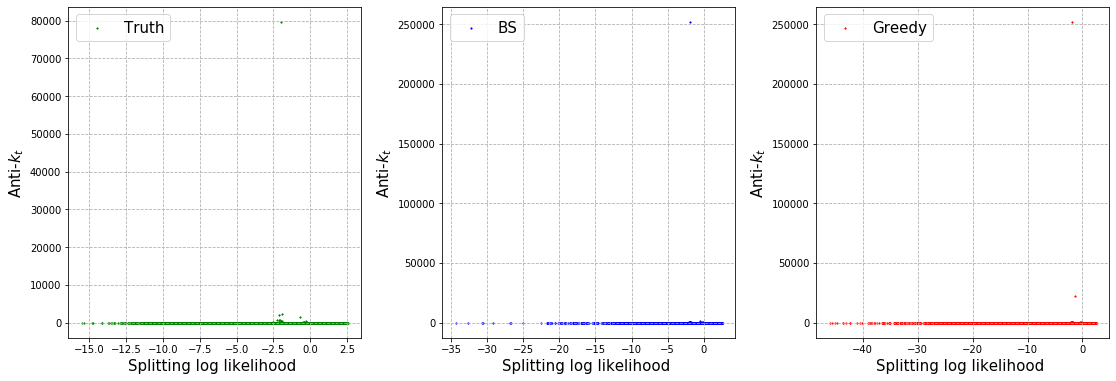

In [493]:
jetdijs = truth_dic["dijs"]
nameY = "Anti-$k_t$"
nameX ="Splitting log likelihood"
title = ""
jetdijs2 = BSO_dic["dijs"]
jetdijs3 = Greedy_dic["dijs"]
LabelJetdijs = "Truth"
LabelJetdijs2 = "BS"
LabelJetdijs3 = "Greedy"


fig2, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig2.set_size_inches(15, 5)

plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)
markersize = 1

ax1.scatter(jetdijs[0], jetdijs[1], color="green", marker="X", s=markersize, label=LabelJetdijs)
ax2.scatter(jetdijs2[0], jetdijs2[1], color="blue", marker="X", s=markersize, label=LabelJetdijs2)
ax3.scatter(jetdijs3[0], jetdijs3[1], color="red", marker="X", s=markersize, label=LabelJetdijs3)

ax1.legend(loc="best",  fontsize=15)
ax1.set_xlabel(r"%s "%nameX, fontsize=15)
ax1.set_ylabel(r"%s "%nameY, fontsize=15)
ax1.grid(which='both', axis='both', linestyle='--')

ax2.legend(loc="best",  fontsize=15)
ax2.set_xlabel(r"%s "%nameX, fontsize=15)
ax2.set_ylabel(r"%s "%nameY, fontsize=15)
ax2.grid(which='both', axis='both', linestyle='--')

ax3.legend(loc="best",  fontsize=15)
ax3.set_xlabel(r"%s "%nameX, fontsize=15)
ax3.set_ylabel(r"%s "%nameY, fontsize=15)
ax3.grid(which='both', axis='both', linestyle='--')




# plt.legend(loc='best', fontsize=15)
plt.grid(which='both', axis='both', linestyle='--')
plt.title(r"%s"%title, fontsize=20)
plt.show()

# Beam Search implementations: Beam Size Comparisons

In [104]:
importlib.reload(bs)
importlib.reload(BSO)

<module 'scripts.beamSearchOptimal' from '/Users/sebastianmacaluso/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/beamSearchOptimal.py'>

In [105]:
def truthLogLH(truth_jet,k=0):
    """ Truth jet log likelihood """
    
    likelihood.enrich_jet_logLH(truth_jet)
        
    LogLH = np.sum(truth_jet["logLH"]) 
    
    return LogLH

In [106]:
def reclustGreedyJet(truth_jet):
    """ Greedy jet reclustering """

    greedyJet = N2Greedy.recluster(
        truth_jet,
        delta_min =  truth_jet["pt_cut"] ,
        lam = float(truth_jet["Lambda"]),
        visualize = False,
    )
    
    GreedyLogLH = sum(greedyJet["logLH"])
    
    return greedyJet, GreedyLogLH

In [107]:
def beamSize_BSOList(truth_jet, beamsizeList, Nbest =1):
    """ Beam size scan for the Optimal Beam Search algorithm"""

    BSOtimeList=[]
    BSO_jets =[]

    for i in beamsizeList:  

            startTime= time.time()

            BSO_jets.append(
                BSO.recluster( 
                truth_jet, 
                beamSize = i,
                delta_min =  truth_jet["pt_cut"],
                lam = float(truth_jet["Lambda"]),
                N_best = Nbest,
            )[0]  
            )

            BSOtimeList.append(time.time() -startTime)
            
    BSO_jetsLogLH = [sum(jet["logLH"]) for jet in BSO_jets]
    
    return BSOtimeList, BSO_jets, BSO_jetsLogLH

### Beam size scan and plotting  functions

In [109]:
def BeamSizeLogLH(jetsName,  filename="", k=0):
    
    with open(input_dir+ str(jetsName) + '.pkl', "rb") as fd: 
        truth_jet = pickle.load(fd, encoding='latin-1')[int(k)]
    
    truthConst = N2Greedy.getConstituents(
    truth_jet,
	truth_jet["root_id"],
	[],
    )
    
    N = len(truthConst)
    
    likelihood.enrich_jet_logLH(truth_jet)
        
    truthLogLH = np.sum(truth_jet["logLH"]) 
    
    greedyJet, GreedyLogLH = reclustGreedyJet(truth_jet)

    
    beamsizeList = np.minimum(np.concatenate(([1],np.arange(0.5,5.5,0.5)*N)),np.asarray(N*(N-1)/2 *np.ones(11))).astype(int)
#     beamsizeList = np.array(([1]))

    BSOtimeList, BSO_jets, BSO_jetsLogLH = beamSize_BSOList(truth_jet, beamsizeList )
    
    bstimeList, bs_jets, bs_jetsLogLH = beamSize_BSList(truth_jet, beamsizeList )
    
    with open("data/beamScanJets/jets"+str(filename)+".pkl", "wb") as f: 
        pickle.dump((
            truth_jet,
            truthLogLH, 
            greedyJet,
            GreedyLogLH, 
            BSOtimeList,
            BSO_jets,
            BSO_jetsLogLH, 
            bstimeList, 
            bs_jets,
            bs_jetsLogLH
        ), f) 
    
    return beamsizeList

In [110]:
def plotBeamSizeLogLH(beamsizeList = None, filename=""):

        with open("data/beamScanJets/jets"+str(filename)+".pkl", "rb") as fd:  
                truth_jet,\
                truthLogLH, \
                greedyJet,\
                GreedyLogLH,\
                BSOtimeList,\
                BSO_jets,\
                BSO_jetsLogLH, \
                bstimeList, \
                bs_jets,\
                bs_jetsLogLH = pickle.load(fd, encoding='latin-1')
                

        N = BSO_jets[0]["Nconst"]
        beamsizeList = np.minimum(np.concatenate(([1],np.arange(0.5,5.5,0.5)*N)),np.asarray(N*(N-1)/2 *np.ones(11))).astype(int)
                
        truthConst = N2Greedy.getConstituents(
        truth_jet,
        truth_jet["root_id"],
        [],
        )
    
        N = len(truthConst)
        
        print("Number of leaves = ",N)

        fig2, (ax1)= plt.subplots(nrows=1, ncols=1)
        fig2.set_size_inches(16,8)
        plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)
        markersize = 100
        ax1.scatter(beamsizeList/N , BSO_jetsLogLH, color='blue', marker="s", s=markersize, label = "bs Optimal")
        ax1.scatter(beamsizeList/N , bs_jetsLogLH, color="red", marker ="o", s=markersize, label = "bs")
        ax1.scatter(1/N, GreedyLogLH, color="Green", marker = "X", s=markersize, label = "Greedy")
        ax1.scatter(1/N, truthLogLH, color="black", marker = "d", s=markersize, label = "Truth")
        ax1.grid(which='both',axis='both',linestyle='--')
        ax1.set_xlabel(r"(Beam Size)/(# leaves)", fontsize=15)
        ax1.set_ylabel("Jet log likelihood", fontsize=15)
        plt.title('Beam Size search', fontsize = 25)
        plt.legend(loc='best', fontsize=15)
        plt.grid(which='both',axis='both',linestyle='--')

### Log likelihoood vs beam size plots 

In [114]:
"""Data dir"""
input_dir= 'data/old/'
jets = "tree_100_truth"

with open(input_dir+ str(jets) + '.pkl', "rb") as fd: 
    truth_jets = pickle.load(fd, encoding='latin-1')

In [115]:
"""Number of jet constituents"""
Nconst100 = []
for jet in truth_jets:
    Nconst100.append(len(jet["leaves"]))
    
NconstAvg100 =np.average(Nconst100)
display(NconstAvg100)

36.82

In [117]:
""" Find jet location in list for a specific number of leaves"""
for i,N in enumerate(Nconst100):
    if 12>N>9:
        print("Jet #",i,"N const = ",N )

Jet # 72 N const =  11


In [118]:
startTime = time.time()
beamsizeList = BeamSizeLogLH("tree_100_truth", filename="100_72",k=72)
print("Total time = ",time.time() - startTime)

Total time =  2.057978868484497


Number of leaves =  11


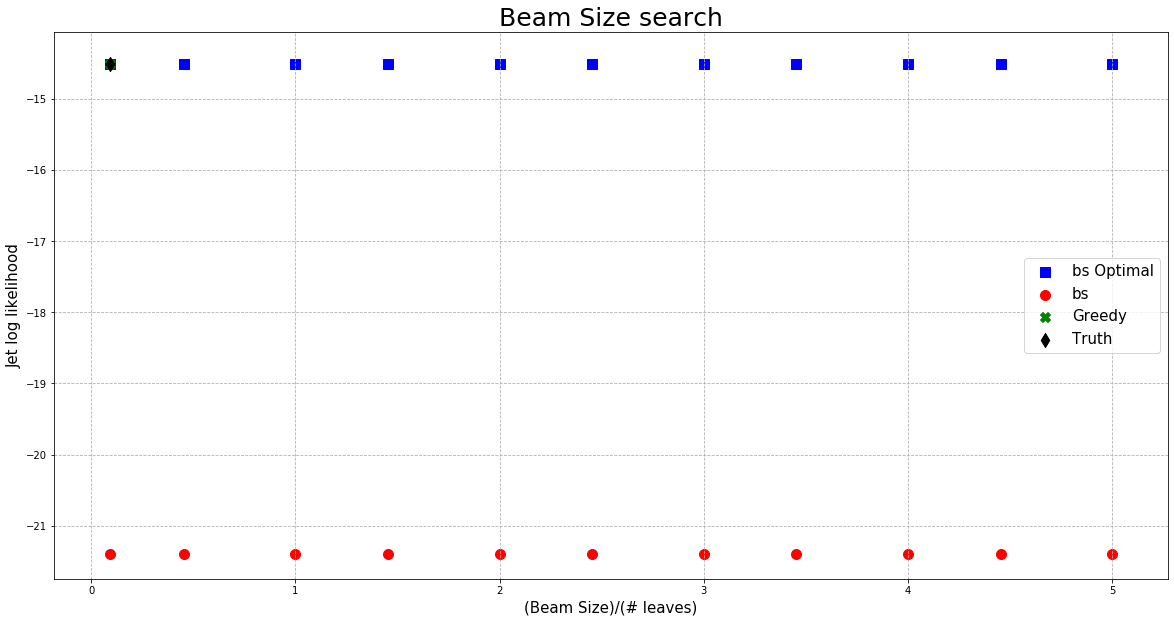

In [119]:
plotBeamSizeLogLH( filename="100_72")

In [120]:
startTime = time.time()
beamsizeList = BeamSizeLogLH("tree_100_truth", filename="100_34",k=34)
print("Total time = ",time.time() - startTime)

Total time =  20.85628390312195


Number of leaves =  22


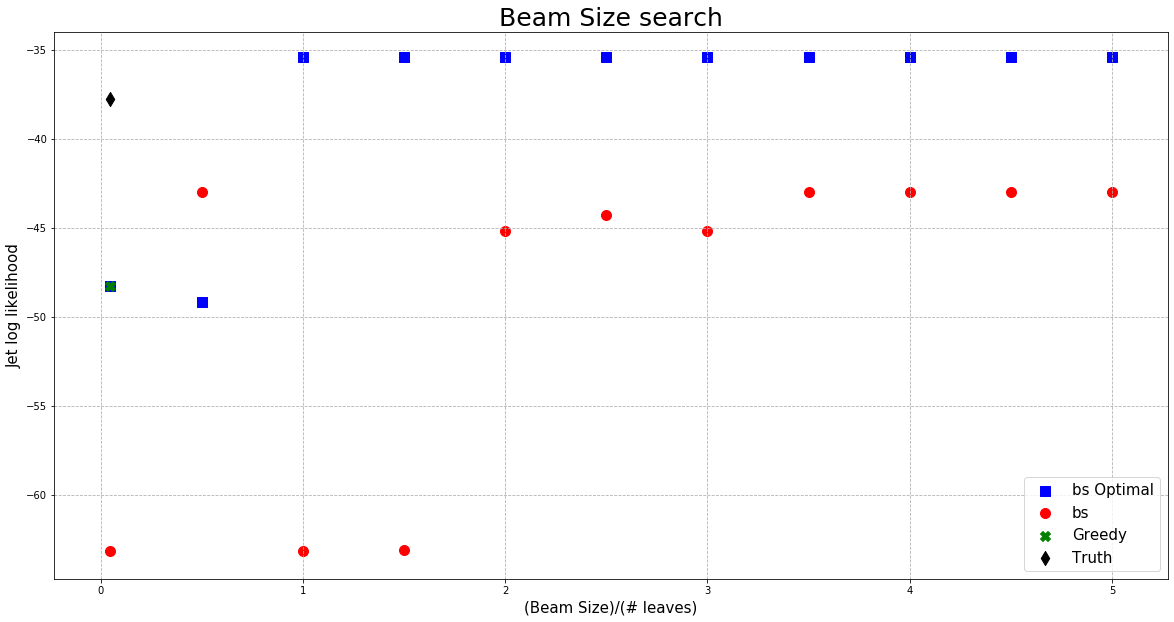

In [121]:
plotBeamSizeLogLH( filename="100_34")

In [122]:
startTime = time.time()
beamsizeList = BeamSizeLogLH("tree_100_truth", filename="100_70",k=70)
print("Total time = ",time.time() - startTime)

Total time =  346.0549330711365


Number of leaves =  50


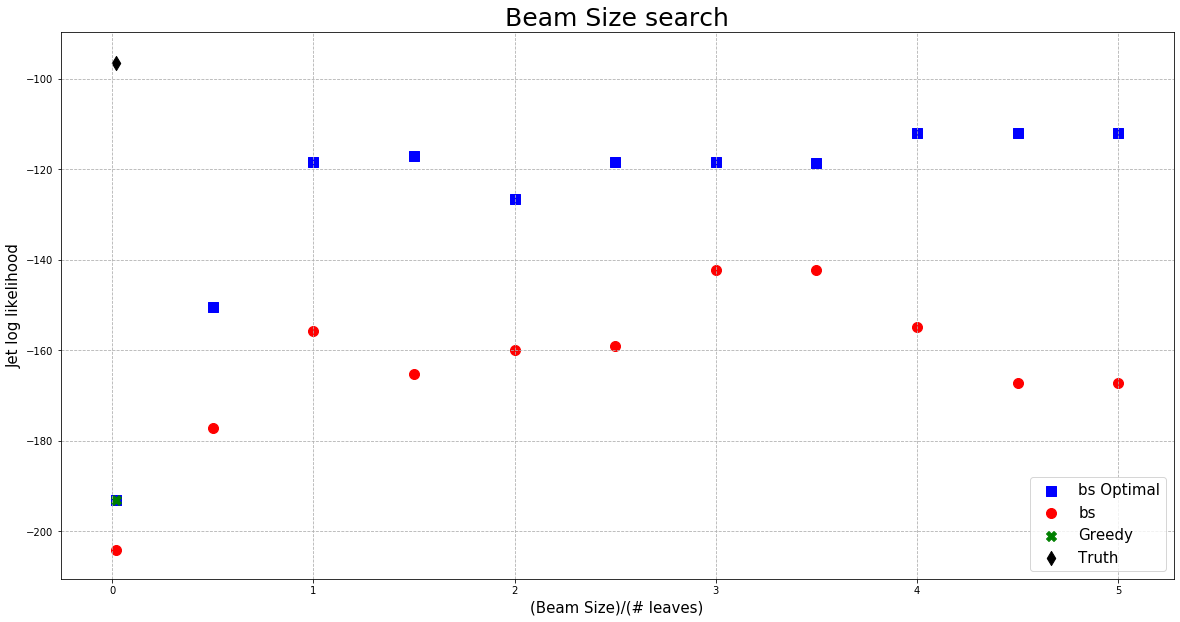

In [123]:
plotBeamSizeLogLH( filename="100_70")

In [124]:
startTime = time.time()
beamsizeList = BeamSizeLogLH("tree_100_truth", filename="100_62",k=62)
print("Total time = ",time.time() - startTime)

Total time =  4663.079787015915


Number of leaves =  98


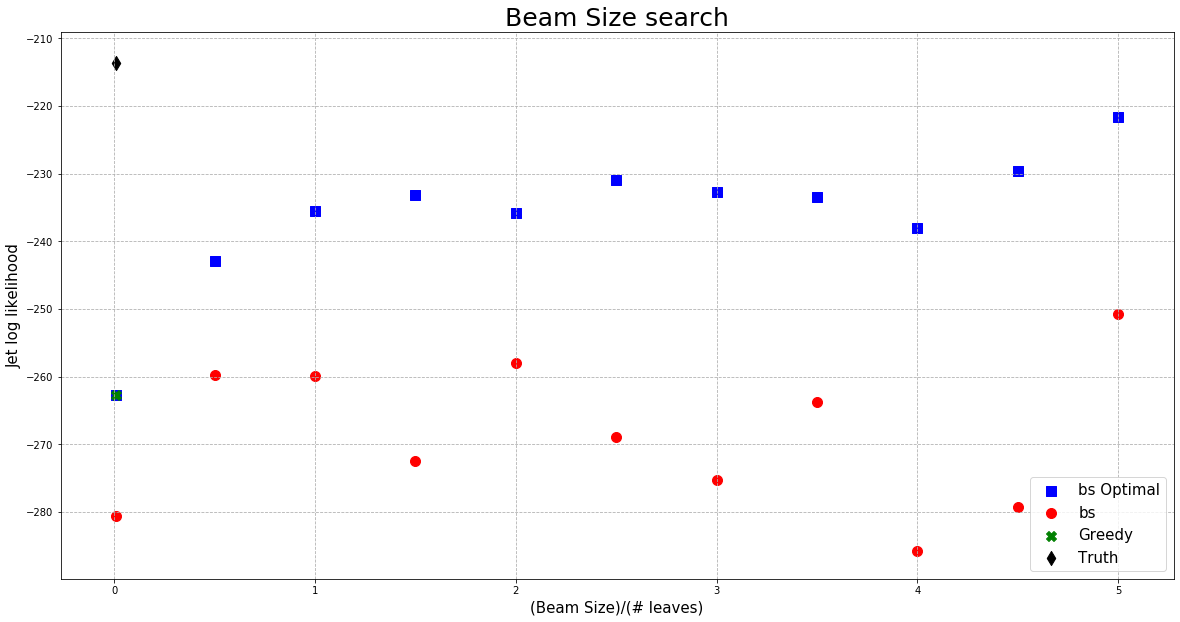

In [125]:
plotBeamSizeLogLH( filename="100_62")

## TESTS AND CODE COMPARISONS

In [151]:
def getLastSplittingProb(inputJet, node_id):
    """
    Recursive function to get a list of the tree leaves
    """
    jet = copy.deepcopy(inputJet)

    probList=[]

    left_node_id = jet["tree"][node_id,0]
    right_node_id = jet["tree"][node_id,1]
    
    if jet["tree"][left_node_id,0] == -1 and jet["tree"][right_node_id,0] == -1:
        
        probList.append(jet["logLH"][node_id - 97])
    
#     elif jet["tree"][node_id, 0] == -1:

# 		continue

    elif jet["tree"][node_id, 0] != -1:
        getLastSplittingProb(
        jet,
        jet["tree"][node_id, 0],
        )

        getLastSplittingProb(
        jet,
        jet["tree"][node_id, 1],
        )

    return probList

In [152]:
BSO_jetLastSplittingProb = getLastSplittingProb(BSO_jets[0], BSO_jets[0]["root_id"])

In [154]:
BSO_jetLastSplittingProb

[]

In [153]:
sum(BSO_jetLastSplittingProb)

0

In [32]:
# BSO_jets[0]

In [147]:
len(BSO_jets[0]["logLH"])

97

In [148]:
97+98

195

In [115]:
# BSO_jet

In [243]:
test =  bs.recluster( 
            truth_jet, 
            beamSize = 10,
            delta_min =  truth_jet["pt_cut"],
            lam = float(truth_jet["Lambda"]),
            N_best = 1,
        )[-1]  

In [244]:
test =  BSO.recluster( 
            truth_jet, 
            beamSize = 10,
            delta_min =  truth_jet["pt_cut"],
            lam = float(truth_jet["Lambda"]),
            N_best = 1,
        )[-1]  

## Duccio's beam search

In [116]:
importlib.reload(beamsearchTJS)

<module 'scripts.beamsearchTJS' from '/Users/sebastian/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/beamsearchTJS.py'>

In [93]:
len(truthConst)

30

In [97]:
truthConst = N2Greedy.getConstituents(
    truth_jet,	
	truth_jet["root_id"],
	[],
)

In [98]:
truthConstTriple = np.concatenate((truthConst,np.array([[0.]]*len(truthConst))),axis=1)

In [127]:
beam_Size = 20

In [128]:
a = time.time()
djet_bs_beam1 = beamsearchTJS.build_beamsearch_tree_TJS(truthConstTriple, 1, truth_jet["pt_cut"], float(truth_jet["Lambda"]))
b = time.time()
display(b-a)

0.1830611228942871

In [129]:
a = time.time()
djet_bs = beamsearchTJS.build_beamsearch_tree_TJS(truthConstTriple, beam_Size, truth_jet["pt_cut"], float(truth_jet["Lambda"]))
b = time.time()
display(b-a)

34.568865060806274

In [130]:
a = time.time()
beamSearch_jets = bs.recluster( 
    truth_jet, 
    beamSize = beam_Size,
    delta_min =  truth_jet["pt_cut"],
    lam = float(truth_jet["Lambda"]),
    N_best = 1,
)
b = time.time()
display(b-a)

10.727005958557129

In [131]:
np.sum(djet_bs["logLH"])

-74.47946266489937

In [132]:
np.sum(beamSearch_jets[-1]["logLH"])

-74.47946197240074

In [133]:
34.57/10.72

3.2248134328358207

In [126]:
8.48/2.48

3.4193548387096775